In [77]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.optimize as sco

# Polynome de degré $n = 2p + 1$ 

## Fonctions

In [78]:
def f(x,h):
    x = x*h
    return 2*x**3 + x**2 + 2 

def g(x,h):
    x = x*h
    return x**3 + 2

def h(x,h):
    x = x*h
    return np.cos(x)

def k(x,h):
    x = x*h
    return x + 1
fonctions_test = [f,g,h,k]

In [113]:
def f(x,h):
    x = x*h
    return 2*x**17 + x**10 - x**2 + 2 # - 1.85

def g(x,h):
    x = x*h
    return 0.5 + np.abs(x - 0.5) #- 0.75

def t(x,h):
    if h == 1 :
        h = 9/10
    x = x*h
    return 1/(1-x) #-1.5

def j(x,h):
    x = x*h
    return 1/ ( 1 + 25*(2*x-1)**2 ) #- 1

def k(x,h):
    x = x*h
    return 10**5 * x**10 * (1-x)**7 + 0.01

def q(x,h):
    x = x*h
    return 10 * (x-1/2)**4 #+ 0.01

def creneau(x,h):
    x = x*h
    return (x<0.2*h)*0 + (x>0.8*h)*0 + (0.2*h<=x)*1 + (x<=0.8*h)*1

def sinoffset(x,h):
    x = x*h
    return np.sin(x)+1.2

def gaussienne(x,h):
    x = x*h
    m = 1/2
    sigma = 1/10
    return np.exp(-(x-m)**2/2/sigma**2) / (2*np.pi)/sigma

def gaussienne2(x,h):
    x = x*h
    m = 1/2 * h
    sigma = 1/1000
    return np.exp(-(x-m)**2/2/sigma**2) / (2*np.pi)/sigma




fonctions_test = [f,g,t,j,k,q,creneau,sinoffset,gaussienne,gaussienne2]

## Initialisation

In [101]:
def init_X(p):
    # initialise les points alpha0 et beta0 (3.10) 
    i = np.linspace(0,p,p+1)
    X = np.zeros(2*(p+1))
    X[:p+1] = 1/2*(1-np.cos((2*i+1)*np.pi/(2*p+1)))
    X[p+1:] = 1/2*(1-np.cos(2*i*np.pi/(2*p+1)))
    return X

In [102]:
def test_init(p):
    X = init_X(p)
    plt.plot(X[:p+1],np.ones(len(X[:p+1])),'ob')
    plt.plot(X[p+1:],np.ones(len(X[p+1:])),'or')

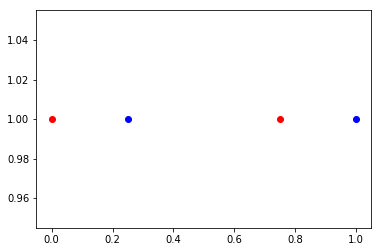

In [103]:
p = 1
test_init(p)

## Operateur S

In [104]:
def S (p,eps,X0):
    # séparation en alpha et beta
    alpha = X0[:p]
    beta = X0[p:]

    # creation des delta pour alpha et beta
    delta_alpha = np.concatenate((alpha,[1]))
    delta_alpha[1:] -= alpha
    
    delta_beta = - np.concatenate(([0],beta))
    delta_beta[:-1] += beta
    delta_beta[-1] += 1 
    
    # creation des delta_tilde pour alpha et beta
    delta_alpha_t = np.zeros(p+1)
    delta_beta_t = np.zeros(p+1)
    for i in range (p+1):
        delta_alpha_t[i] = max(delta_alpha[i],2*eps)
        delta_beta_t[i] = max(delta_beta[i],2*eps)

    delta_alpha_t = delta_alpha_t / np.sum(delta_alpha_t)
    delta_beta_t = delta_beta_t / np.sum(delta_beta_t)

    # mise a jour des alpha et beta, directement dans x
    X = np.zeros(2*p)
    X[0] = delta_alpha_t[0]
    X[p] = delta_beta_t[0]
    for i in range (1,p):
        X[i] = X[i-1] + delta_alpha_t[i]
        X[i+p] = X[i-1+p] + delta_beta_t[i]
    
    return X

In [105]:
def test_S(a):
    print(a)
    Speps = S(4,0.1,a)
    print(Speps)

    plt.plot(Speps[:4],np.ones(4),'or')
    plt.plot(Speps[4:],np.ones(4),'ob')

[0.1, 0.35, 0.5, 0.8, 0.07, 0.39, 0.65, 0.85]
[0.17391304 0.39130435 0.56521739 0.82608696 0.16949153 0.44067797
 0.66101695 0.83050847]


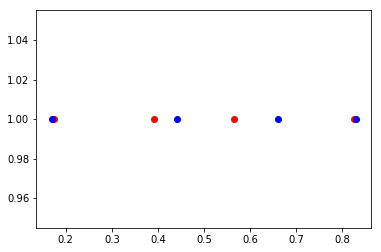

In [106]:
a = [0.1,0.35,0.5,0.8,0.07,0.39,0.65,0.85]
test_S(a)

# Algorithme

In [107]:
def Jp(p,f,h,X,epsilon):
    # calcule la jacobienne
    i = np.linspace(0,p-1,p)
    theta_i = 2*(p-i)*np.pi/(2*p+1)
    D_alpha = 2*p*np.cos(p*theta_i)/(np.cos(theta_i)-1) + np.sin(p*theta_i)/np.sin(theta_i) * 2 * (p - 1/(np.cos(theta_i)-1))
    
    i = np.linspace(1,p,p)
    eta_i = (2*(p-i)+1)*np.pi/(2*p+1)
    D_beta = 2*p*np.cos(p*eta_i)/(np.cos(eta_i)+1) + np.sin(p*eta_i)/np.sin(eta_i) * 2* (p + 1/(np.cos(eta_i)+1))
    
    feps = max( np.max(f(X,h)),epsilon) #cf partie 4
    return  np.sqrt(feps) * sps.diags(np.concatenate((D_alpha,D_beta))).toarray()

def b_beta (p,f,h,beta,x,epsilon):
    # calcule la fonction b[beta] au point x
    res = 0
    for i in range (p+1):
        somme = (-1)**(i+p)*np.sqrt(max(f(beta[i],h),epsilon)/(1-beta[i])) 
        pro = 1
        for j in range (p+1):
            if i != j :
                pro *=  (x - beta[j])/(beta[i]-beta[j])
        somme *= pro
        res  += somme
    return res
  

def a_alpha (p,f,h,alpha,x,epsilon):
    # calcule la fonction a[alpha] au point x
    res = 0
    for i in range (p+1):
        somme = (-1)**(i+p)*np.sqrt(max(f(alpha[i],h),epsilon)/(alpha[i])) 
        pro = 1
        for j in range (p+1):
            if i != j :
                pro *=  (x - alpha[j])/(alpha[i]-alpha[j])
        somme *= pro
        res += somme
    return res
     
def f_theta(X,p,f,h,epsilon):
    # fonction à minimiser - [a[alpha](beta), b[beta](alpha)]
    alpha = X[:p]
    alpha_1 = np.concatenate((alpha,[1]))
    beta = X[p:]
    beta_0 = np.concatenate(([0],beta))
    return np.concatenate(( b_beta(p,f,h,beta_0,alpha,epsilon), a_alpha(p,f,h,alpha_1,beta,epsilon) ))

In [108]:
def epsi_S(p):
    #permet de calculer le epsilon propre à l'opérateur Séparateur
    i = np.linspace(0,2*p+1,2*p+2)
    gamma = 1/2*(1-np.cos(i*np.pi/(2*p+1)))
    return min( 1/2/(p+1), np.min((gamma[1:]-gamma[:-1])/3))

def Newton_Raphson (p,f,h,epsilon,s=None,eps=1e-12,itermax=100):
    # reconstruit le polynome le plus interpolant
    epsi = epsi_S(p)
    #initialisation
    X = init_X(p)  
    X = np.concatenate((X[:p],X[p+2:]))
    k=0
    err=2*eps
    Residus = []

    while err > eps and itermax > k :
        X0 = np.copy(X)
        #print(f_theta(X,p,f,h,epsilon))
        d = npl.solve(Jp(p,f,h,X,epsilon),f_theta(X,p,f,h,epsilon))
        X = X - d
        if s != None and s != 0 :
            X = S(p,epsi,X)
        #print(f_theta(X,p,f,h,epsilon))
        k+=1
        err = npl.norm(X-X0)/npl.norm(X0)
        Residus += [err]

    return X,k,Residus


In [109]:
def pn(x,ap,bp): 
    #retourne le polynome à partir de la décompo de Lukas
    return x * ap**2 + (1-x) * bp**2
    
def approxh(x,p,f,h,epsilon,s=None):
    #X = sco.fsolve(f_theta,np.array([1/4,3/4]), args=(p,f,h,epsilon))
    #X = S(p,epsi,X)
    X,itermax,residus = Newton_Raphson(p,f,h,epsilon,s)
    X  = np.concatenate(( X[:p],[1],[0],X[p:]))

    ap = a_alpha(p,f,h,X[:p+1],x,epsilon)
    bp = b_beta(p,f,h,X[p+1:],x,epsilon)
    
    return pn(x,ap,bp),X

In [110]:
def test_approx(p,f,h,epsilon,affichage=None,s=None):
    x = np.linspace(0,1,501)
    px, interp = approxh(x,p,f,h,epsilon,s)

    Ap = a_alpha(p,f,h,interp[:p+1],interp,epsilon)
    Bp = b_beta(p,f,h,interp[p+1:],interp,epsilon)
    
    fx = f(x,h) 

    if affichage != None and affichage != 0 : 
        plt.plot(x,fx,label="f(x)")
        plt.plot(x,px,label="p(x)")
        plt.plot(interp,f(interp,h),'ob')
        plt.plot(interp, pn(interp,Ap,Bp),'or')
        plt.legend()
        name = str(f).split(' ')
        plt.title("Fonction "+name[1]+", p = "+str(p)+", h = "+str(h)+", epsilon = "+str(epsilon))
        plt.savefig("Fonction "+name[1]+", p = "+str(p)+", h = "+str(h)+", epsilon = "+str(epsilon)+".eps", format='eps')
        plt.show()
    
    return px,fx

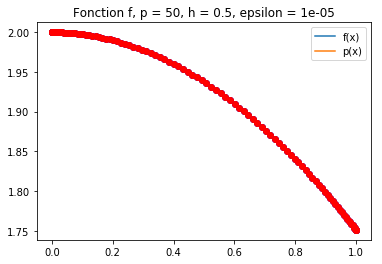

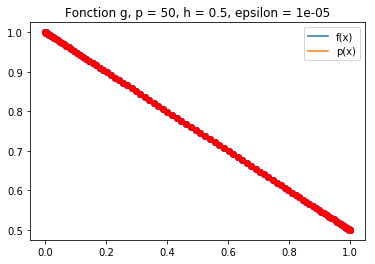

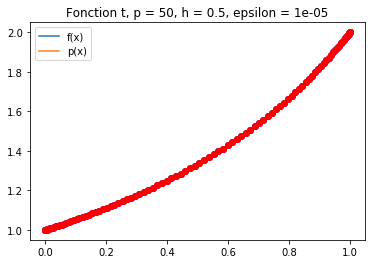

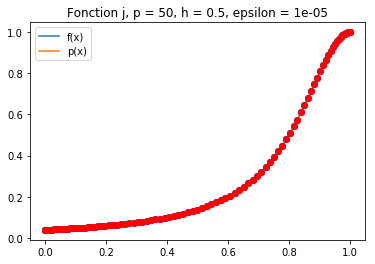

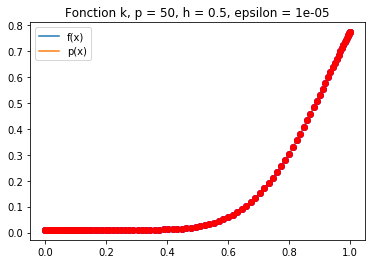

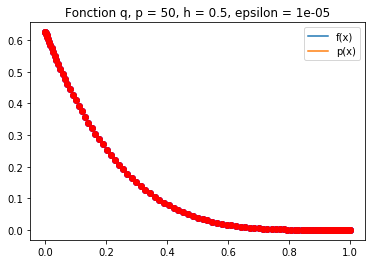

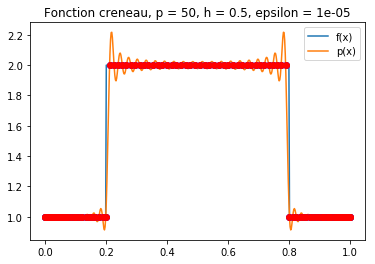

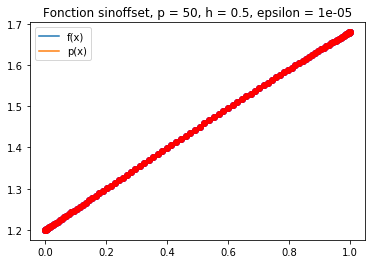

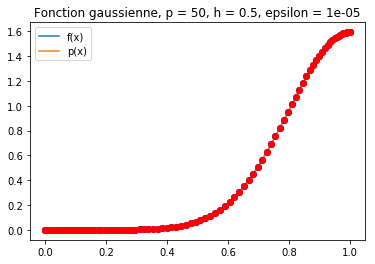

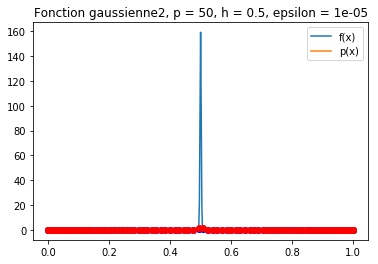

In [117]:
h = 1/2
p = 50
epsilon=1e-5

for fonctions in fonctions_test : 
    test_approx(p,fonctions,h,epsilon,affichage=1,s=1)

--------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

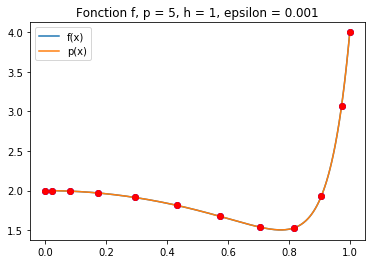

Norme de l'erreur :  n2 = 0.0014438418016829648  ; ninf =  0.00010822207399630024 



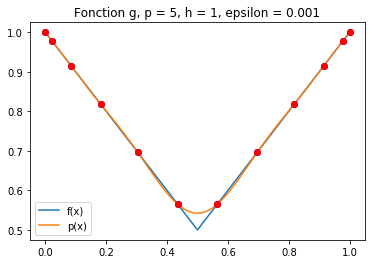

Norme de l'erreur :  n2 = 0.1836189240208148  ; ninf =  0.04224839588061169 



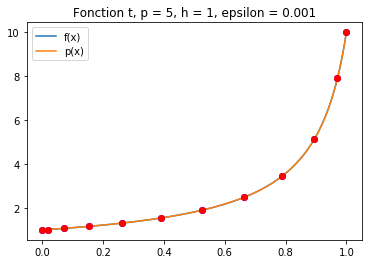

Norme de l'erreur :  n2 = 0.0628253665521111  ; ninf =  0.009700403594022688 



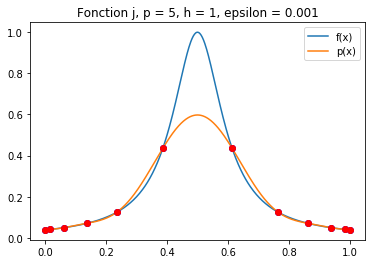

Norme de l'erreur :  n2 = 2.6509991195742866  ; ninf =  0.40245477202756386 



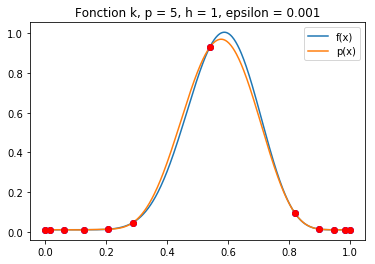

Norme de l'erreur :  n2 = 0.5742445974432966  ; ninf =  0.05621786559895048 



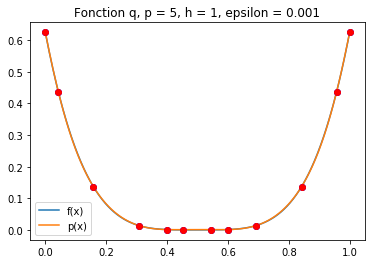

Norme de l'erreur :  n2 = 0.022313902298343923  ; ninf =  0.0020414469573094562 



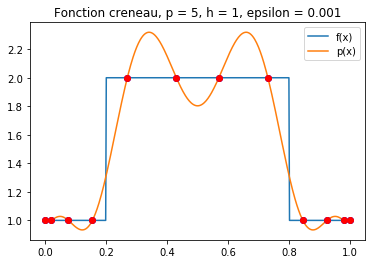

Norme de l'erreur :  n2 = 4.6921367460875985  ; ninf =  0.6807253639296469 



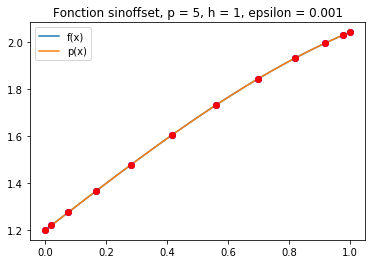

Norme de l'erreur :  n2 = 1.5246883222721845e-14  ; ninf =  2.220446049250313e-15 



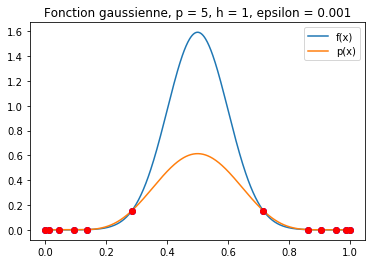

Norme de l'erreur :  n2 = 8.496848149354147  ; ninf =  0.9774759592617943 



In [91]:
h = 1
p = 5
epsilon=0.001

for fonctions in fonctions_test : 
    px,fx = test_approx(p,fonctions,h,epsilon,1)
    print("Norme de l'erreur :  n2 =", npl.norm(px-fx), " ; ninf = ", npl.norm(px-fx,np.inf),"\n")

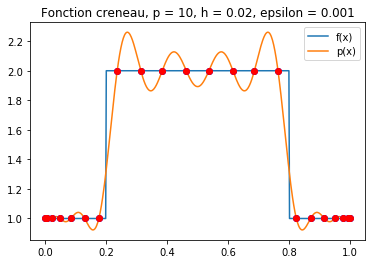

(array([1.        , 1.00246565, 1.00160594, 0.99925619, 0.99664268,
        0.99452313, 0.99330292, 0.99313032, 0.9939737 , 0.99568328,
        0.99803966, 1.00079129, 1.00368257, 1.00647418, 1.00895699,
        1.01096084, 1.01235905, 1.0130697 , 1.0130544 , 1.01231518,
        1.01089002, 1.00884753, 1.00628117, 1.00330321, 1.00003882,
        0.99662035, 0.99318207, 0.98985531, 0.98676432, 0.98402264,
        0.98173013, 0.97997071, 0.97881065, 0.97829752, 0.97845963,
        0.97930612, 0.98082736, 0.98299588, 0.9857676 , 0.98908338,
        0.99287081, 0.99704619, 1.00151663, 1.00618226, 1.01093845,
        1.01567809, 1.02029372, 1.02467969, 1.02873415, 1.03236094,
        1.0354713 , 1.0379854 , 1.03983374, 1.04095828, 1.04131342,
        1.04086672, 1.03959947, 1.03750702, 1.03459891, 1.03089882,
        1.02644432, 1.02128644, 1.01548912, 1.00912845, 1.00229183,
        0.995077  , 0.9875909 , 0.97994858, 0.97227189, 0.96468822,
        0.95732914, 0.95032906, 0.94382384, 0.93

In [92]:
p =10
h  = 0.02
epsilon = 1e-3

test_approx(p,creneau,h,epsilon,1,1)

# Tests

### Erreur algo Newton

In [98]:
def approxh(x,p,f,h,epsilon,s=None):
    #X = sco.fsolve(f_theta,np.array([1/4,3/4]), args=(p,f,h,epsilon))
    #X = S(p,epsi,X)
    X,itermax,residus = Newton_Raphson(p,f,h,epsilon,s)
    
    plt.plot(residus)
    plt.title("Fonction "+name[1]+", p = "+str(p)+", h = "+str(h)+", epsilon = "+str(epsilon))
    plt.show()
    
    X  = np.concatenate(( X[:p],[1],[0],X[p:]))

    ap = a_alpha(p,f,h,X[:p+1],x,epsilon)
    bp = b_beta(p,f,h,X[p+1:],x,epsilon)
    
    return pn(x,ap,bp),X

def test_approx(p,f,h,epsilon,affichage=None,s=None):
    x = np.linspace(0,1,501)
    px, interp = approxh(x,p,f,h,epsilon,s)

    Ap = a_alpha(p,f,h,interp[:p+1],interp,epsilon)
    Bp = b_beta(p,f,h,interp[p+1:],interp,epsilon)
    
    fx = f(x,h) 

    if affichage != None and affichage != 0 : 
        plt.plot(x,fx,label="f(x)")
        plt.plot(x,px,label="p(x)")
        plt.plot(interp,f(interp,h),'ob')
        plt.plot(interp, pn(interp,Ap,Bp),'or')
        plt.legend()
        name = str(f).split(' ')
        plt.title("Fonction "+name[1]+", p = "+str(p)+", h = "+str(h)+", epsilon = "+str(epsilon))
        plt.savefig("Fonction "+name[1]+", p = "+str(p)+", h = "+str(h)+", epsilon = "+str(epsilon)+".eps", format='eps')
        plt.show()
    
    return px,fx

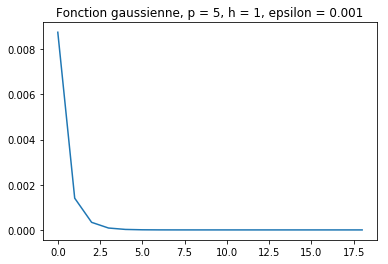

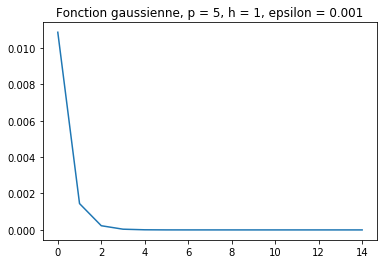

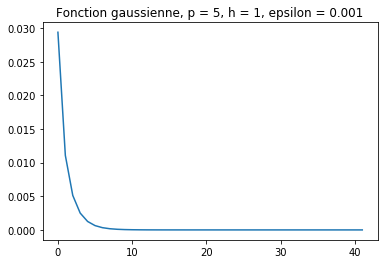

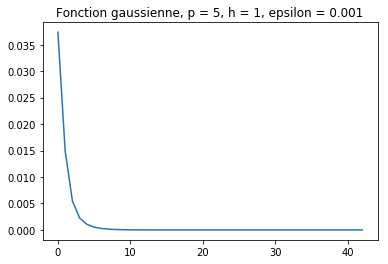

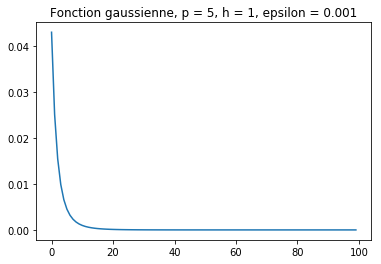

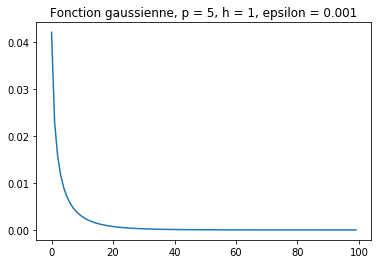

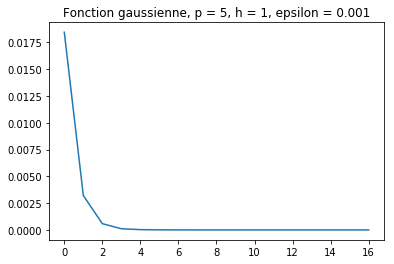

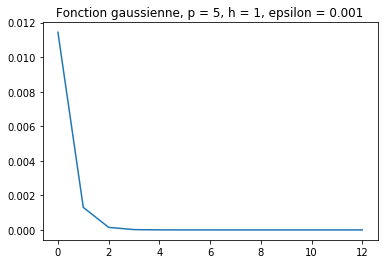

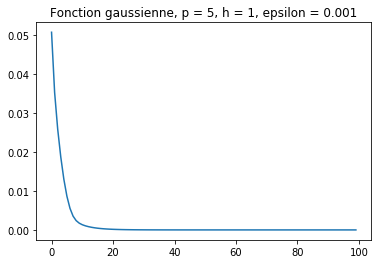

In [99]:
h = 1
epsilon=0.001
p = 5

for fonctions in fonctions_test : 
    px,fx = test_approx(p,fonctions,h,epsilon,0,0)

### Variation de p

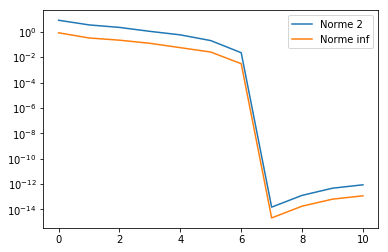

In [17]:
h = 1
epsilon=0.001
p = np.arange(1,12,1)


Err = np.zeros((2,len(p)))

for i in range(len(p)):
    px,fx = test_approx(p[i],k,h,epsilon,0,0)
    Err[0,i] = npl.norm(px-fx)
    Err[1,i] = npl.norm(px-fx,np.inf)
    
plt.semilogy(Err[0,:],label="Norme 2")
plt.semilogy(Err[1,:],label="Norme inf")
plt.legend()

### Variation de h

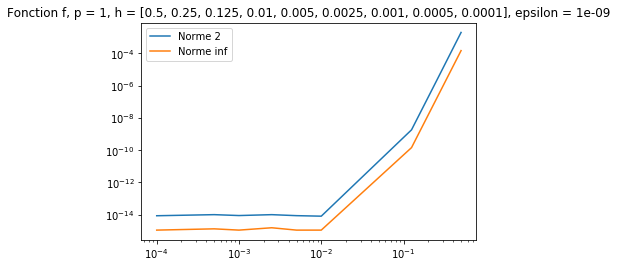

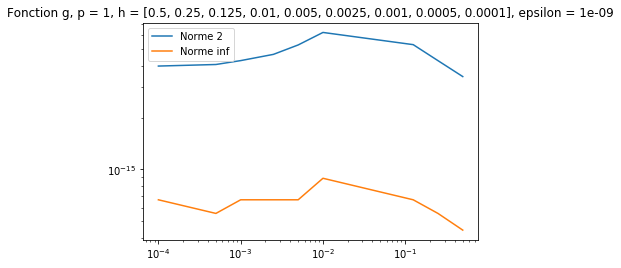

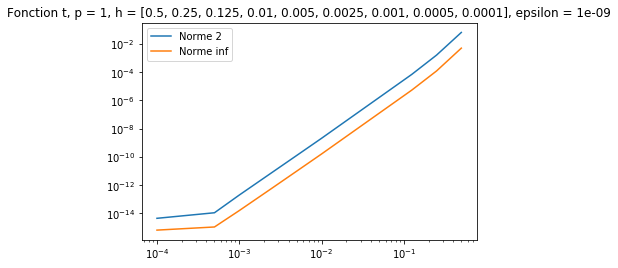

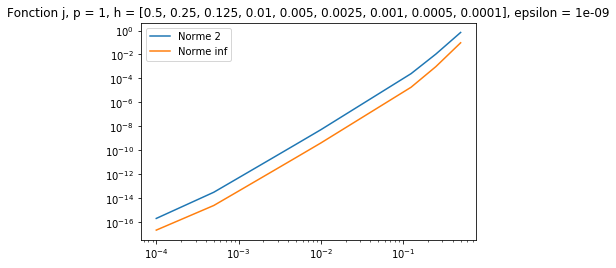

C:\Users\gerie\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt
C:\Users\gerie\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\gerie\Anaconda3\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


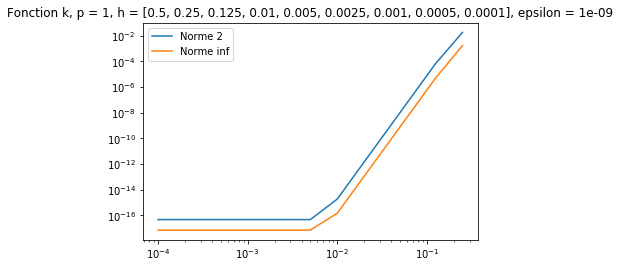

C:\Users\gerie\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


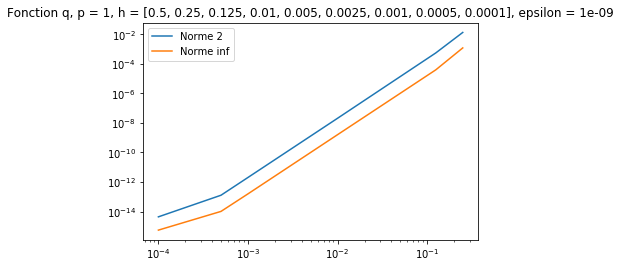

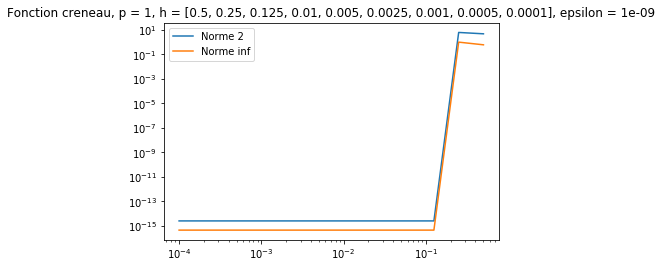

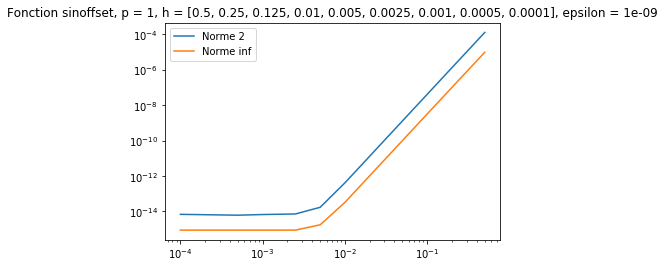

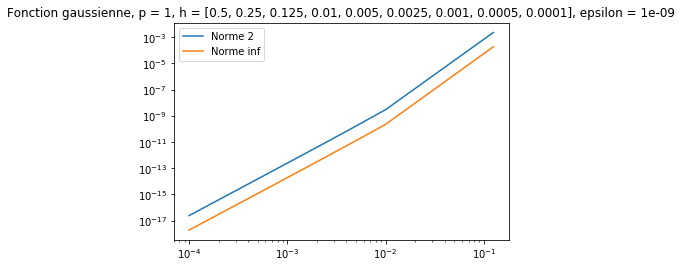

In [18]:
h = [1/2,1/4,1/8,1/100,1/200,1/400,1/1000,1/2000,1/10000]
p = 1
epsilon = 1e-9
Err = np.zeros((2,len(h)))

for f in fonctions_test : 
    for i in range(len(h)):
        px,fx = test_approx(p,f,h[i],epsilon,0)
        Err[0,i] = npl.norm(px-fx)
        Err[1,i] = npl.norm(px-fx,np.inf)

    plt.loglog(h,Err[0,:],label="Norme 2")
    plt.loglog(h,Err[1,:],label="Norme inf")
    name = str(f).split(' ')
    plt.title("Fonction "+name[1]+", p = "+str(p)+", h = "+str(h)+", epsilon = "+str(epsilon))
    plt.legend()
    plt.show()
    

Pb sur le dernier : stagne à 10-2
Origine du pb possible : nb de points insuffisants et/ou epsilon trop grand (si h grand la fonction trop proche de 0 => valeur cachée dans epsilon

## Variation de epsilon

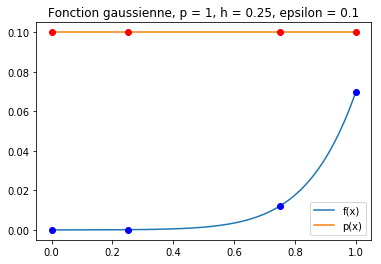

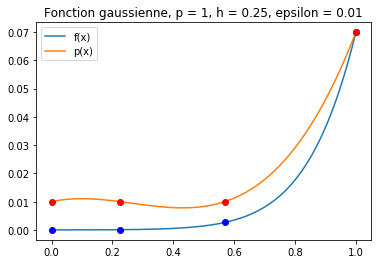

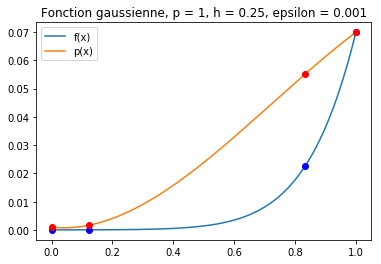

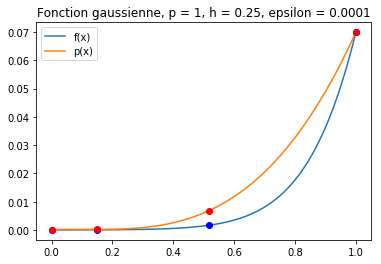

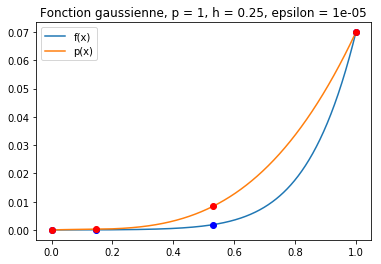

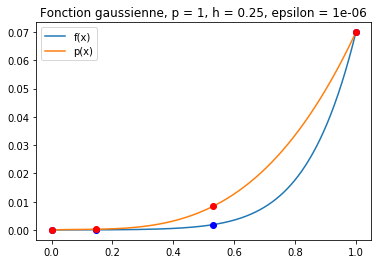

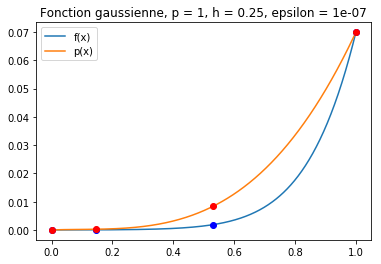

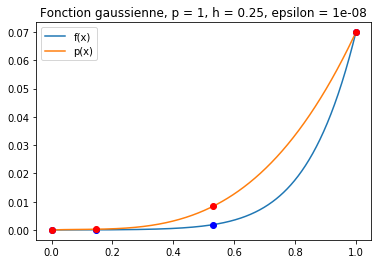

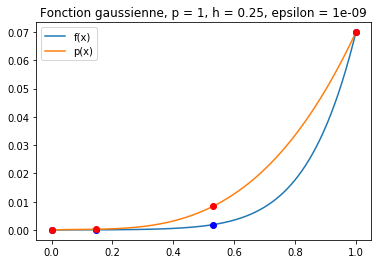

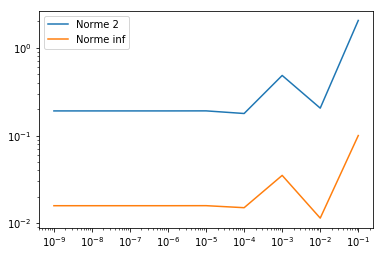

In [19]:
h = 1/4 
p = 1
epsilon = 1/(10**np.arange(1,10,1))
Err = np.zeros((2,len(epsilon)))


for i in range(len(epsilon)):
    px,fx = test_approx(p,gaussienne,h,epsilon[i],1,1)
    Err[0,i] = npl.norm(px-fx)
    Err[1,i] = npl.norm(px-fx,np.inf)

plt.loglog(epsilon,Err[0,:],label="Norme 2")
plt.loglog(epsilon,Err[1,:],label="Norme inf")
plt.legend()
plt.show()

## Tests sur l'opérateur S

In [53]:
def absolu(x,h):
    x = x*h - 0.5*h
    return np.abs(x)

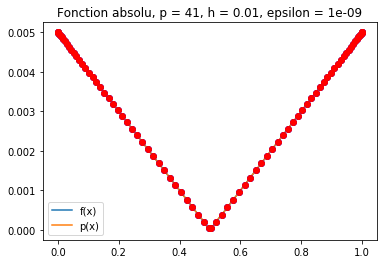

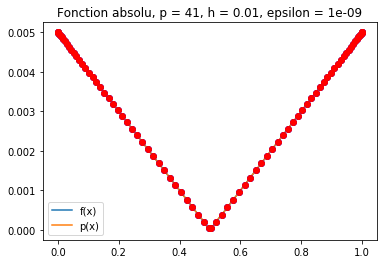

Sans opérateur Séparateur : Norme 2 : 7.413037086480497e-05
Avec opérateur Séparateur : Norme 2 : 7.413037086480485e-05


In [58]:
h = 1e-2
p = 41
epsilon = 1e-9
sansS = test_approx(p,absolu,h,epsilon,1,0)
avecS = test_approx(p,absolu,h,epsilon,1,1)

print("Sans opérateur Séparateur : Norme 2 :", npl.norm(sansS[0]-sansS[1]))
print("Avec opérateur Séparateur : Norme 2 :", npl.norm(avecS[0]-avecS[1]))

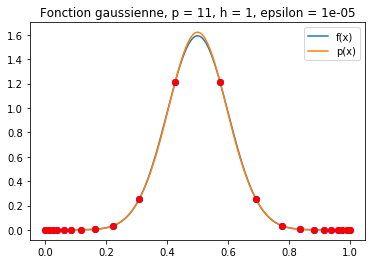

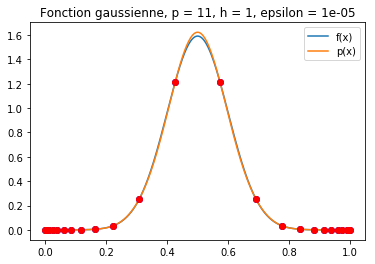

Sans opérateur Séparateur : Norme 2 : 0.1999560140269348
Avec opérateur Séparateur : Norme 2 : 0.21398747554163303


In [22]:
h = 1
p = 11
epsilon = 1e-5
sansS = test_approx(p,gaussienne,h,epsilon,1,0)
avecS = test_approx(p,gaussienne,h,epsilon,1,1)

print("Sans opérateur Séparateur : Norme 2 :", npl.norm(sansS[0]-sansS[1]))
print("Avec opérateur Séparateur : Norme 2 :", npl.norm(avecS[0]-avecS[1]))

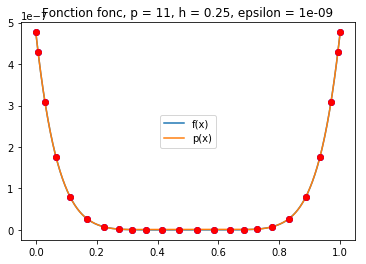

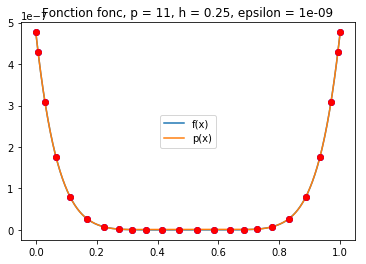

Sans opérateur Séparateur : Norme 2 : 1.336165820360473e-08
Avec opérateur Séparateur : Norme 2 : 1.3361658203604783e-08


In [23]:
def fonc(x,h):
    x = x*h - 1/8
    return np.abs(x**7) 

h = 1/4
p = 11
epsilon = 1e-9
sansS = test_approx(p,fonc,h,epsilon,1,0)
avecS = test_approx(p,fonc,h,epsilon,1,1)

print("Sans opérateur Séparateur : Norme 2 :", npl.norm(sansS[0]-sansS[1]))
print("Avec opérateur Séparateur : Norme 2 :", npl.norm(avecS[0]-avecS[1]))

### Fonction négative en partie

In [60]:
def q(x,h,l,m):
    x = x*h
    return 10 * (x-1/2)**4 + l * m

def q(x,h,l):
    x = x*h
    return 10 * (x-1/2)**4 + l

In [61]:
def Jp(p,f,h,argf,X,epsilon):
    # calcule la jacobienne
    i = np.linspace(0,p-1,p)
    theta_i = 2*(p-i)*np.pi/(2*p+1)
    D_alpha = 2*p*np.cos(p*theta_i)/(np.cos(theta_i)-1) + np.sin(p*theta_i)/np.sin(theta_i) * 2 * (p - 1/(np.cos(theta_i)-1))
    
    i = np.linspace(1,p,p)
    eta_i = (2*(p-i)+1)*np.pi/(2*p+1)
    D_beta = 2*p*np.cos(p*eta_i)/(np.cos(eta_i)+1) + np.sin(p*eta_i)/np.sin(eta_i) * 2* (p + 1/(np.cos(eta_i)+1))

    feps = max( np.max(f(X,h,*argf)),epsilon) #cf partie 4
    return  np.sqrt(feps) * sps.diags(np.concatenate((D_alpha,D_beta))).toarray()

def b_beta (p,f,h,argf,beta,x,epsilon):
    # calcule la fonction b[beta] au point x
    res = 0
    for i in range (p+1):
        somme = (-1)**(i+p)*np.sqrt(max(f(beta[i],h,*argf),epsilon)/(1-beta[i])) 
        pro = 1
        for j in range (p+1):
            if i != j :
                pro *=  (x - beta[j])/(beta[i]-beta[j])
        somme *= pro
        res  += somme
    return res
  

def a_alpha (p,f,h,argf,alpha,x,epsilon):
    # calcule la fonction a[alpha] au point x
    res = 0
    for i in range (p+1):
        somme = (-1)**(i+p)*np.sqrt(max(f(alpha[i],h,*argf),epsilon)/(alpha[i])) 
        pro = 1
        for j in range (p+1):
            if i != j :
                pro *=  (x - alpha[j])/(alpha[i]-alpha[j])
        somme *= pro
        res += somme
    return res
     
def f_theta(X,p,f,h,argf,epsilon):
    # fonction à minimiser - [a[alpha](beta), b[beta](alpha)]
    alpha = X[:p]
    alpha_1 = np.concatenate((alpha,[1]))
    beta = X[p:]
    beta_0 = np.concatenate(([0],beta))
    return np.concatenate(( b_beta(p,f,h,argf,beta_0,alpha,epsilon), a_alpha(p,f,h,argf,alpha_1,beta,epsilon) ))

In [62]:
def epsi_S(p):
    #permet de calculer le epsilon propre à l'opérateur Séparateur
    i = np.linspace(0,2*p+1,2*p+2)
    gamma = 1/2*(1-np.cos(i*np.pi/(2*p+1)))
    return min( 1/2/(p+1), np.min((gamma[1:]-gamma[:-1])/3))

def Newton_Raphson (p,f,h,argf,epsilon,s=None,eps=1e-12,itermax=100):
    # reconstruit le polynome le plus interpolant
    epsi = epsi_S(p)
    #initialisation
    X = init_X(p) 
    X = np.concatenate((X[:p],X[p+2:]))
    k=0
    err=2*eps
    Residus = []
    
    while err > eps and itermax > k :
        X0 = np.copy(X)
        #print(f_theta(X,p,f,h,epsilon))
        d = npl.solve(Jp(p,f,h,argf,X,epsilon),f_theta(X,p,f,h,argf,epsilon))
        X = X - d
        if s != None or s != 0 :
            X = S(p,epsi,X)
        #print(f_theta(X,p,f,h,epsilon))
        k+=1
        err = npl.norm(X-X0)/npl.norm(X0)
        Residus += [err]

    return X,k,Residus

In [63]:
def pn(x,ap,bp): 
    #retourne le polynome à partir de la décompo de Lukas
    return x * ap**2 + (1-x) * bp**2
    
def approxh(x,p,f,h,argf,epsilon,s=None):
    #X = sco.fsolve(f_theta,np.array([1/4,3/4]), args=(p,f,h,epsilon))
    #X = S(p,epsi,X)
    X,itermax,residus = Newton_Raphson(p,f,h,argf,epsilon,s)
    X  = np.concatenate(( X[:p],[1],[0],X[p:]))

    ap = a_alpha(p,f,h,argf,X[:p+1],x,epsilon)
    bp = b_beta(p,f,h,argf,X[p+1:],x,epsilon)
    
    return pn(x,ap,bp),X

In [64]:
def test_approx(p,f,h,argf,epsilon,affichage=None,s=None):
    x = np.linspace(0,1,501)
    px, interp = approxh(x,p,f,h,argf,epsilon,s)

    Ap = a_alpha(p,f,h,argf,interp[:p+1],interp,epsilon)
    Bp = b_beta(p,f,h,argf,interp[p+1:],interp,epsilon)
    
    fx = f(x,h,*argf) 
    
    if affichage != None or affichage != 0 : 
        plt.plot(x,fx,label="f(x)")
        plt.plot(x,px,label="p(x)")
        plt.plot(interp,f(interp,h,*argf),'ob')
        plt.plot(interp, pn(interp,Ap,Bp),'or')
        plt.legend()
        name = str(f).split(' ')
        plt.title("Fonction "+name[1]+", p = "+str(p)+", h = "+str(h)+", epsilon = "+str(epsilon))
        plt.savefig("Fonction "+name[1]+", p = "+str(p)+", h = "+str(h)+", epsilon = "+str(epsilon)+".eps", format='eps')
        plt.show()
    
    return px,fx

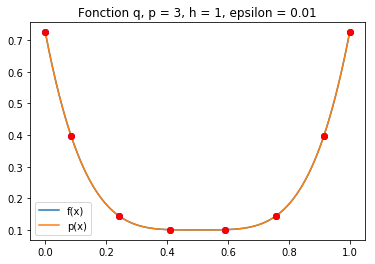

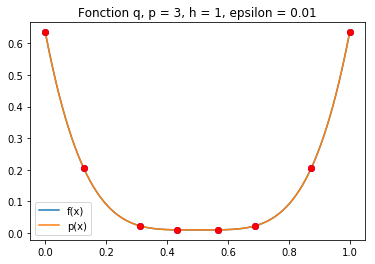

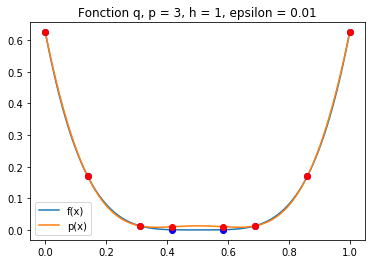

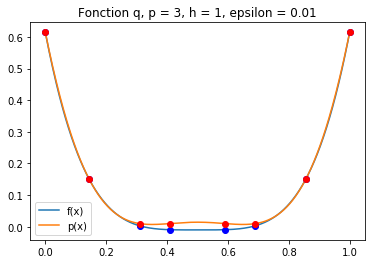

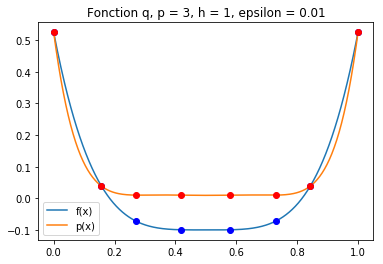

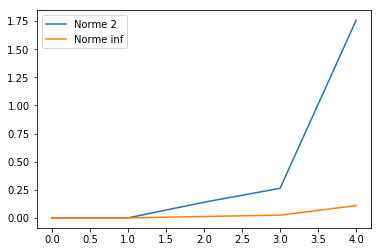

In [65]:
h = 1
p = 3
epsilon=0.01
l = [[0.1],[0.01],[0],[-0.01],[-0.1]]
Err = np.zeros((2,len(l)))

for i in range(len(l)):
    px,fx = test_approx(p,q,h,l[i],epsilon,1)
    Err[0,i] = npl.norm(px-fx)
    Err[1,i] = npl.norm(px-fx,np.inf)
    
plt.plot(Err[0,:],label="Norme 2")
plt.plot(Err[1,:],label="Norme inf")
plt.legend()

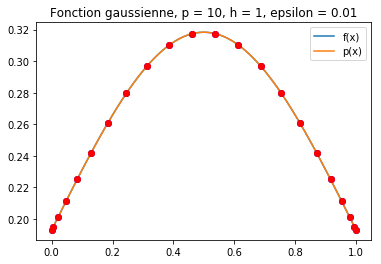

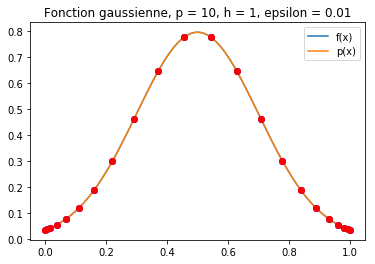

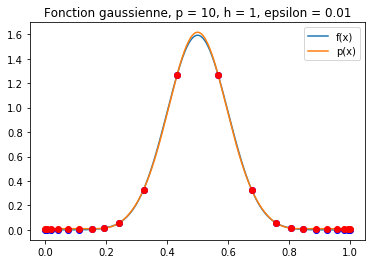

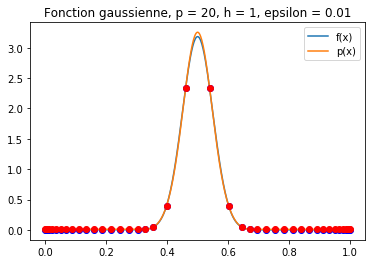

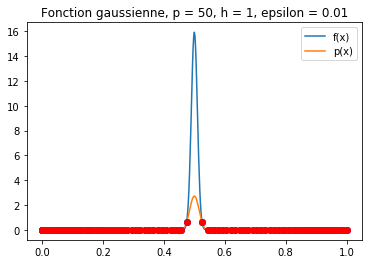

In [74]:
def gaussienne(x,h,sigma):
    x = x*h
    m = 1/2
    #sigma = 1/10
    return np.exp(-(x-m)**2/2/sigma**2) / (2*np.pi)/sigma

h = 1
p = [10,10,10,20,50]
epsilon=0.01
l = [[1/2],[1/5],[1/10],[1/20],[1/100]]
Err = np.zeros((2,len(l)))

for i in range(len(l)):
    px,fx = test_approx(p[i],gaussienne,h,l[i],epsilon,1)
    Err[0,i] = npl.norm(px-fx)
    Err[1,i] = npl.norm(px-fx,np.inf)
    
#plt.plot(Err[0,:],label="Norme 2")
#plt.plot(Err[1,:],label="Norme inf")
#plt.legend()